### Loading Required Libraries

In [4]:
# import the necessary libraries
from wordcloud import WordCloud
from modules import PreProcessing, functions
from sqlite3 import connect 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
from collections import Counter
import nltk
import re
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# to ensure all changes are reflected 
# in-case jupyter notebook was already oppened

from importlib import reload
reload(PreProcessing)
reload(functions)

project_dir = '/Users/nima/repository/Project_509'

### Section 1 - Create a Suport vector machine 

In [5]:
databse_file = 'database.db'
main = connect(databse_file)

sql_statement_laod_data = '''
SELECT 
    reviews.id, 
    reviews.course_name, 
    reviews.star,
    review_text_clean.clean_sentence 

FROM review_text_clean
JOIN reviews ON 
    review_text_clean.review_id = reviews.id
'''

# this will be used at the end to join the tokens
# refer to last block of code where df_org is used
df_org = pd.read_sql_query(sql_statement_laod_data, main)

df = df_org.copy()

# create a new column that holds tokens of clean_sentence
df['tokens'] = df['clean_sentence'].apply(lambda x: x.split(' '))
df.sample(5)

,id,course_name,star,clean_sentence,tokens
39884,39884,python-network-data,4.0,nice,[nice]
33386,33386,python-network-data,5.0,veri good explain enjoy lesson exercis ran iss...,"[veri, good, explain, enjoy, lesson, exercis, ..."
35372,35372,python-network-data,5.0,teacher veri nice cours veri interest,"[teacher, veri, nice, cours, veri, interest]"
39630,39630,python-network-data,4.0,sourc code could explanatori,"[sourc, code, could, explanatori]"
58276,58276,learning-how-to-learn,5.0,thi cours realli good scientificli explain lea...,"[thi, cours, realli, good, scientificli, expla..."


In [6]:
# It is observed that there are tokens with only one character
# its best to remove them as well as they are just adding noise and complexity of the model

def remove_single_character_tokens(row, min_length=3):
    return [word for word in row['tokens'] if len(word) >= min_length]

df['tokens_keep'] = df.apply(remove_single_character_tokens, axis=1)

df['tokens_keep'].sample(5)

10890    [veri, nice, cours, realli, like, concept, cle...
6308                               [beauti, design, cours]
38995    [would, star, rate, provid, deep, detail, prac...
13762    [would, say, thi, cours, best, understand, exc...
14490    [excelent, curso, ejemplo, prã¡ctica, permitie...
Name: tokens_keep, dtype: object

In [7]:
def exclude_words_that_are_rarely_used(counter_all, min_count=5):
    # remove words that appear less than min_count
    # this will be used to remove the words that are not frequently used
    # since the model can't learn from them effectively

    word_count_before = len(counter_all)
    counter_after = {token:count for token, count in counter_all.items() if count > min_count}
    word_count_after = len(counter_after)
    percentage_dropped = (word_count_before - word_count_after) / word_count_before * 100
    words_dropped = word_count_before - word_count_after

    print('%s rare words (%s) could be dropped to improve the model.' 
          % (f'{words_dropped:,}',f'{percentage_dropped:.1f}%'))
    
    print('unique words before: %s\nunique words after: %s' 
          % (f'{word_count_before:,}', f'{word_count_after:,}'))
    
    return counter_after
    
# using itertool count each elements in tokens column
counter_all = Counter(chain.from_iterable(df['tokens']))
counter_reduced = exclude_words_that_are_rarely_used(counter_all, min_count=5)
words_to_keep = counter_reduced.keys()

20,751 rare words (82.4%) could be dropped to improve the model.
unique words before: 25,194
unique words after: 4,443


In [8]:
# if each word in words_to_keep is a char not between a-z or 0-9 then remove
words_to_keep_english_alphabet = \
    [word for word in words_to_keep if re.match(r'^[a-z0-9]+$', word)]

dropped_words_count = \
    len(words_to_keep) - len(words_to_keep_english_alphabet)
    
print('unique words before: %s' % (f'{len(words_to_keep):,}'
    '\nSubset of words that only contain english alphabet and digits: %s\n\n' 
    % f'{len(words_to_keep_english_alphabet):,}'))

print("There are %s rows that may confuse the model as majority of the reviews are in english.\n"
      "These rows will be dropped to narrow the model prediction to english words only" 
      % dropped_words_count)

unique words before: 4,443
Subset of words that only contain english alphabet and digits: 4,117


There are 326 rows that may confuse the model as majority of the reviews are in english.
These rows will be dropped to narrow the model prediction to english words only


In [9]:
# remove the elements in tokens that are not in words_to_keep
def return_words_to_use(row, words_to_keep):
    return [word for word in row['tokens'] if word in words_to_keep]

df['tokens_keep'] = \
    df.apply(lambda row: return_words_to_use(row, words_to_keep_english_alphabet), axis=1)


# difference in number of tokens before and after removing the words that are not used often
def get_number_of_words_dropped(row):
    return len(row['tokens']) - len(row['tokens_keep'])

df['number_of_words_dropped'] = df.apply(get_number_of_words_dropped, axis=1)

# sort the dataframe by number_of_words_dropped
df.sort_values(by='number_of_words_dropped', ascending=False, inplace=True)

df.head()

,id,course_name,star,clean_sentence,tokens,tokens_keep,number_of_words_dropped
9725,9725,excel-essentials,5.0,ù ø§ ø´ø§ø¡ ø§ùùù ùø§ ùùø© ø¥ùø§ ø¨ø§ù...,"[ù, ø§, ø´ø§ø¡, ø§ùùù, ùø§, ùùø©, ø¥ùø§...","[mr, nicki, bull, dr, prashan, professor, yvon...",148
50350,50350,learning-how-to-learn,5.0,ðñðµðºñð°ñð½ñð¹ ðºñññ ðð¾ð¹ ñð¸ð´ð±ñ...,"[ðñðµðºñð°ñð½ñð¹, ðºñññ, ðð¾ð¹, ñð¸ð...","[mind, number]",129
50693,50693,learning-how-to-learn,5.0,ð­ñð¾ ð¼ð¾ð¹ ð¿ðµñð²ñð¹ ðºñññ ðºð¾ñð¾ñ...,"[ð­ñð¾, ð¼ð¾ð¹, ð¿ðµñð²ñð¹, ðºñññ, ðºð¾ñ...",[coursera],114
50434,50434,learning-how-to-learn,3.0,ð­ññ ð±ñ ð²ð¾ð´ñ ð´ð° ð² ð·ð°ñññð»ð¸ð²ñ...,"[ð­ññ, ð±ñ, ð²ð¾ð´ñ, ð´ð°, ð², ð·ð°ñññð...",[],102
50478,50478,learning-how-to-learn,5.0,trã¨ intã©ress je le recommand pour le amoureu...,"[trã¨, intã©ress, je, le, recommand, pour, le,...","[je, le, recommand, pour, le, de, lapprentissa...",91


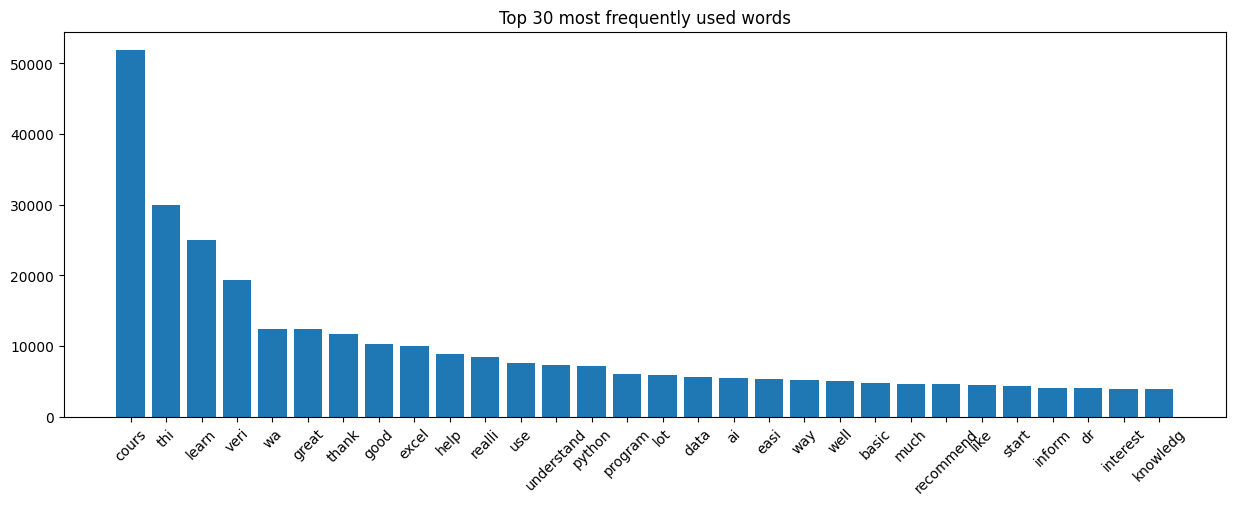

In [10]:
words_count = Counter(chain.from_iterable(df['tokens_keep']))

# plot the top 20 most frequently used in words_to_train_with
plt.figure(figsize=(15,5))
plt.title('Top 30 most frequently used words')
plt.bar(*zip(*words_count.most_common(30)))
plt.xticks(rotation=45)
plt.show()

In [11]:
def descriptive_stats(tokens, most_common_tokens_number = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = len(set(tokens))/len(tokens)
    num_characters = len("".join(tokens))
        
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        most_common_tokens_list = Counter(tokens).most_common(most_common_tokens_number)
        print(f'\nMost Common Tokens are:\n{most_common_tokens_list}')
        
        
# Get descriptive_stats for each course_name

course_names = df['course_name'].unique()
for course_name in course_names:
    df_course = df[df['course_name'] == course_name]
    tokens = list(chain.from_iterable(df_course['tokens_keep']))
    print('\n\nDescriptive stats for course "%s" is: \n' % course_name)
    descriptive_stats(tokens)



Descriptive stats for course "excel-essentials" is: 

There are 107024 tokens in the data.
There are 2945 unique tokens in the data.
There are 538577 characters in the data.
The lexical diversity is 0.028 in the data.

Most Common Tokens are:
[('cours', 7804), ('excel', 5630), ('thi', 3536), ('veri', 3283), ('learn', 2822)]


Descriptive stats for course "learning-how-to-learn" is: 

There are 240134 tokens in the data.
There are 3701 unique tokens in the data.
There are 1215908 characters in the data.
The lexical diversity is 0.015 in the data.

Most Common Tokens are:
[('cours', 12885), ('learn', 12100), ('thi', 9449), ('veri', 3385), ('help', 3305)]


Descriptive stats for course "python" is: 

There are 215919 tokens in the data.
There are 3579 unique tokens in the data.
There are 1111281 characters in the data.
The lexical diversity is 0.017 in the data.

Most Common Tokens are:
[('cours', 12023), ('thi', 7732), ('python', 5786), ('program', 5054), ('veri', 4785)]


Descriptive 

In [12]:
# list of top 7 common words regardless of course_name
common_words = Counter(chain.from_iterable(df['tokens_keep'])).most_common(7)
common_words = [word for word, count in common_words]
print(common_words)

['cours', 'thi', 'learn', 'veri', 'wa', 'great', 'thank']


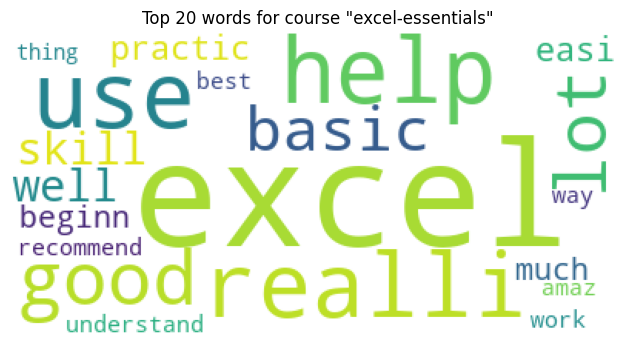

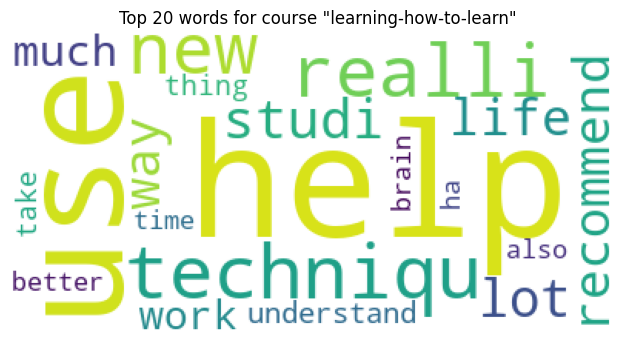

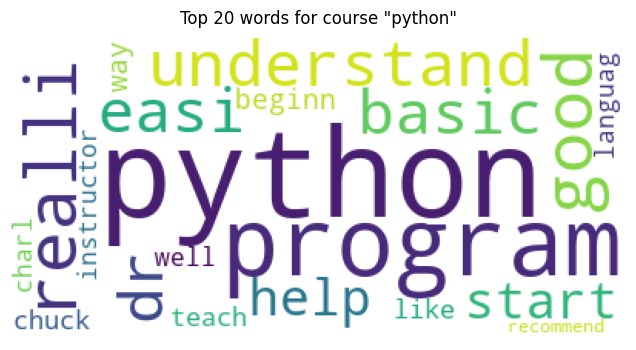

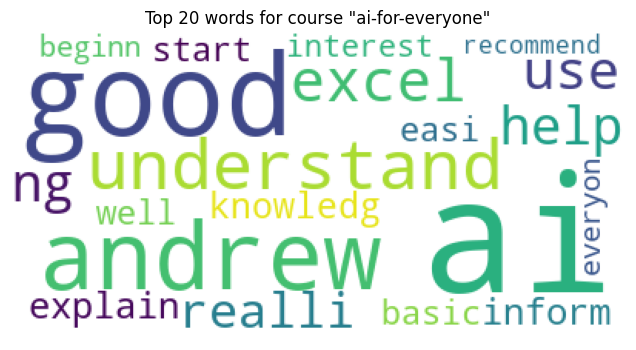

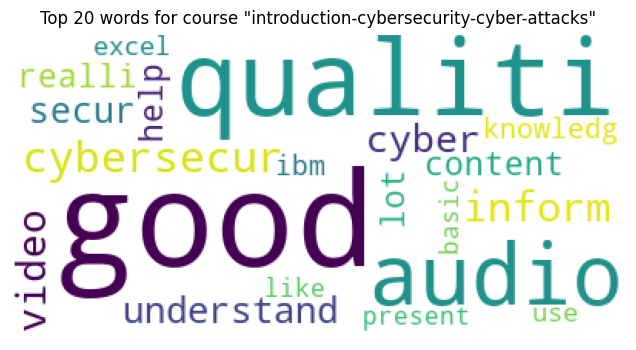

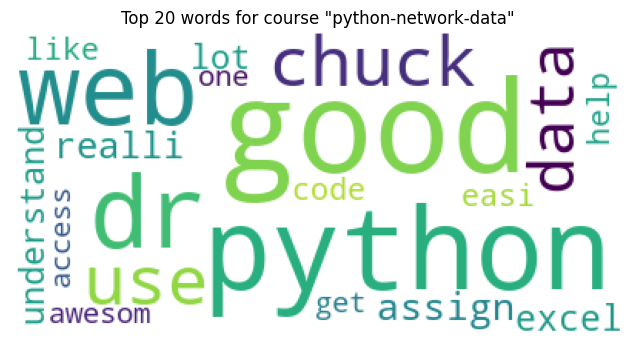

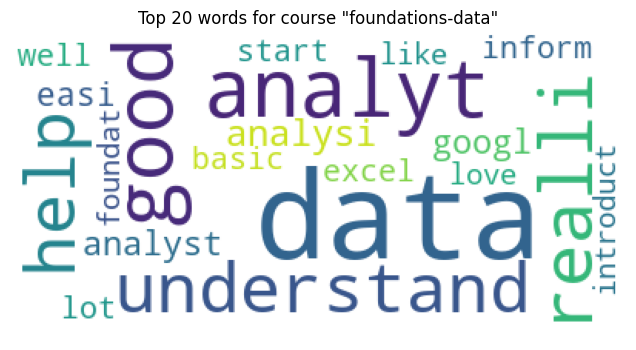

In [13]:
# Since the common words are used a lot, FOR VISUALIZATION ONLY
# removing the top 7 words to help seeing which words show up 
# most frequently in based on course_name. 

# make word cloud of top 20 words for each course_name
for course_name in course_names:
    df_course = df[df['course_name'] == course_name]
    
    # get count of each words in the tokens_keep
    words_count = Counter(chain.from_iterable(df_course['tokens_keep']))
    
    # drop words if they are in common_words
    words_count = {word:count for word, count in words_count.items() if word not in common_words}
     
    wordcloud = WordCloud(max_words=20, background_color='white').generate_from_frequencies(words_count)  
    plt.figure(figsize=(8,4))
    plt.title('Top 20 words for course "%s"' % course_name)
    plt.imshow(wordcloud)
    plt.gca().set_frame_on(True)
    plt.axis("off")
    plt.show()
    print('\n')

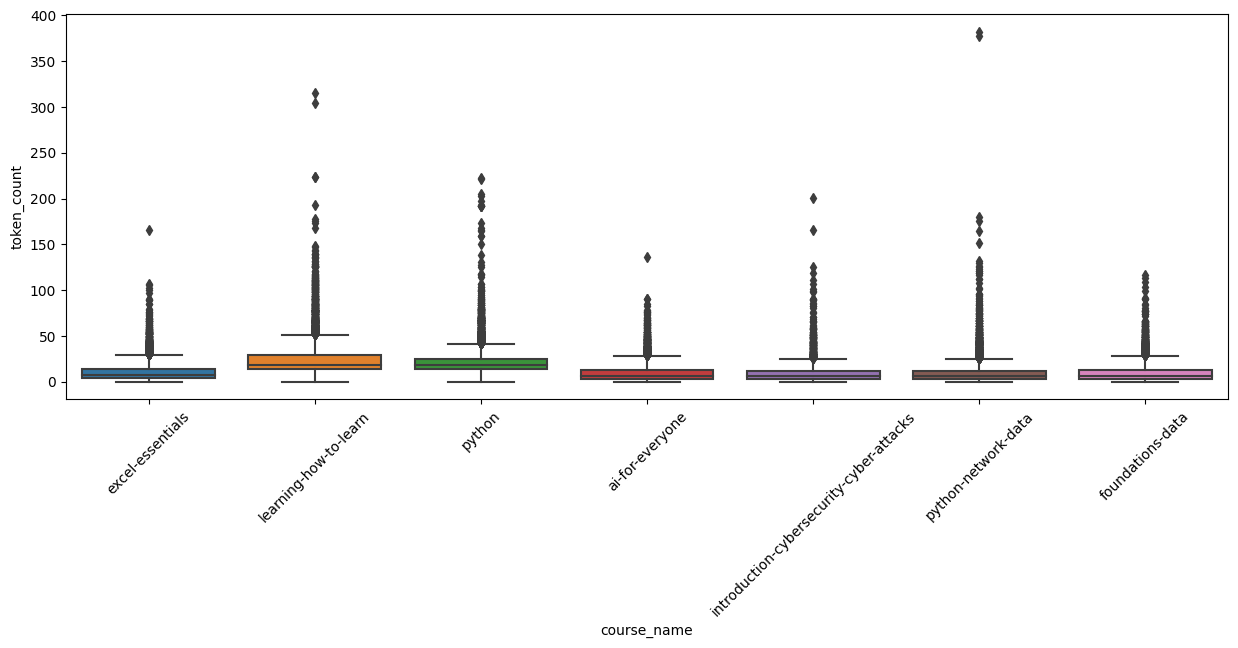

In [14]:
# get count of tokens for each row and save it in 'token_count'
df['token_count'] = df['tokens_keep'].apply(len)

# show boxblox using sns - number of tokens based on course_name
plt.figure(figsize=(15,5))
sns.boxplot(x='course_name', y='token_count', data=df)
plt.xticks(rotation=45)
plt.show()

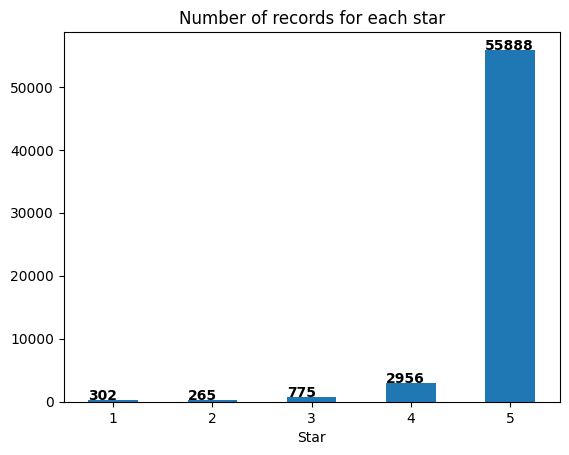

In [17]:
# convert start to int
df['star'] = df['star'].astype(int)

# count the number of records for each star and plot horizontal bar chart
df['star'].value_counts().sort_index().plot(kind='bar')

# make x-axis label horizontal
plt.xticks(rotation=0)

# show star counts for each bar in the plot
for i, v in enumerate(df['star'].value_counts().sort_index()):
    plt.text(i-.25, v, str(v), color='black', fontweight='bold')
plt.title('Number of records for each star')
plt.xlabel('Star')
plt.show()

In [19]:
# add tokens_keep from df to df_org where data is available using id column
df_save_to_db = pd.merge(df_org, df[['id', 'tokens_keep']], on='id', how='left')

# only show id, course_name, tokens_keep for df_save_to_db
# rename tokens_keep to tokens

df_save_to_db = df_save_to_db[['id', 'course_name', 'tokens_keep']]
df_save_to_db.rename(columns={'tokens_keep': 'tokens'}, inplace=True)

# df_save_to_db place space between tokens to be able to save it in database 
df_save_to_db['tokens'] = \
    df_save_to_db['tokens'].apply(lambda x: ' '.join(x))

df_save_to_db.to_sql('review_tokens', main)

main.commit()
main.close()